In [1]:
from tqdm import tqdm
import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/


In [3]:
# data_flag = 'pathmnist'
data_flag = 'pneumoniamnist'
download = True

NUM_EPOCHS = 50
BATCH_SIZE = 32
learning_rate = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [4]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/caesar/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/caesar/.medmnist/pneumoniamnist.npz


In [5]:
(x_train, y_train) = (train_dataset.imgs, train_dataset.labels)
(x_test, y_test) = (test_dataset.imgs, test_dataset.labels)

In [6]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 4708
    Root location: /home/caesar/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 624
    Root location: /home/caesar/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}

In [7]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [8]:
x_train.shape, x_test.shape

((4708, 28, 28), (624, 28, 28))

In [9]:
x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))

In [10]:
x_train.shape, x_test.shape

((4708, 28, 28, 1), (624, 28, 28, 1))

In [11]:
# Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow
import tensorflow as tf

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

2024-01-20 17:29:37.127175: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-20 17:29:37.152825: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-20 17:29:37.152861: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-20 17:29:37.153504: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-20 17:29:37.158186: I tensorflow/core/platform/cpu_feature_guar

In [12]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
import numpy as np
import matplotlib.pyplot as plt
tf.__version__
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Reshape, Flatten


autoencoder = Sequential()

# Encoder
autoencoder.add(Conv2D(filters = 16, kernel_size=(3,3), activation='relu', padding='valid', input_shape=(28,28,1)))
autoencoder.add(MaxPooling2D(pool_size=(2,2)))

autoencoder.add(Conv2D(filters = 8, kernel_size=(3,3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#autoencoder.summary()

autoencoder.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding = 'same', strides=(2,2)))

autoencoder.add(Flatten())

#autoencoder.summary()

# Decoder

autoencoder.add(Reshape((4,4,8)))
#autoencoder.summary()
autoencoder.add(Conv2D(filters = 8, kernel_size=(3,3), activation='relu', padding='same'))
#autoencoder.summary()
autoencoder.add(UpSampling2D(size=(2,2)))
#autoencoder.summary()

autoencoder.add(Conv2D(filters = 8, kernel_size=(3,3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D(size=(2,2)))

autoencoder.add(Conv2D(filters = 16, kernel_size=(3,3), activation='relu'))
autoencoder.add(UpSampling2D(size=(2,2)))

autoencoder.add(Conv2D(filters = 1, kernel_size=(3,3), activation='sigmoid', padding='same'))
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 flatten (Flatten)           (None, 128)               0

In [13]:
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [14]:
autoencoder.fit(x_train, x_train, epochs = 50)

Epoch 1/50
  1/148 [..............................] - ETA: 1:53 - loss: 0.6914 - accuracy: 1.5944e-04

2024-01-20 17:29:43.852324: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff84c1e98b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-01-20 17:29:43.852358: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-01-20 17:29:43.867395: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705789783.971111 4172062 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-01-20 17:29:43.972439: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-01-20 17:29:43.972912: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


 28/148 [====>.........................] - ETA: 0s - loss: 0.6750 - accuracy: 2.4201e-05

2024-01-20 17:29:44.056087: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-01-20 17:29:44.112856: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


148/148 [==============================] - 2s 8ms/step - loss: 0.6559 - accuracy: 8.0681e-04
Epoch 2/50
148/148 [==============================] - 1s 8ms/step - loss: 0.6397 - accuracy: 0.0012
Epoch 3/50
148/148 [==============================] - 1s 8ms/step - loss: 0.6363 - accuracy: 0.0012
Epoch 4/50
148/148 [==============================] - 1s 8ms/step - loss: 0.6343 - accuracy: 0.0012
Epoch 5/50
148/148 [==============================] - 1s 8ms/step - loss: 0.6328 - accuracy: 0.0012
Epoch 6/50
 36/148 [======>.......................] - ETA: 0s - loss: 0.6325 - accuracy: 0.0011    

2024-01-20 17:29:49.880519: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


148/148 [==============================] - 1s 8ms/step - loss: 0.6316 - accuracy: 0.0012
Epoch 7/50
 22/148 [===>..........................] - ETA: 0s - loss: 0.6307 - accuracy: 0.0013

2024-01-20 17:29:50.892865: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


148/148 [==============================] - 2s 15ms/step - loss: 0.6309 - accuracy: 0.0012
Epoch 8/50
148/148 [==============================] - 2s 13ms/step - loss: 0.6304 - accuracy: 0.0012
Epoch 9/50
148/148 [==============================] - 1s 8ms/step - loss: 0.6300 - accuracy: 0.0012
Epoch 10/50
148/148 [==============================] - 2s 16ms/step - loss: 0.6297 - accuracy: 0.0012
Epoch 11/50
148/148 [==============================] - 1s 9ms/step - loss: 0.6295 - accuracy: 0.0013
Epoch 12/50
148/148 [==============================] - 2s 11ms/step - loss: 0.6292 - accuracy: 0.0013
Epoch 13/50
148/148 [==============================] - 1s 9ms/step - loss: 0.6291 - accuracy: 0.0013
Epoch 14/50
148/148 [==============================] - 2s 15ms/step - loss: 0.6289 - accuracy: 0.0013
Epoch 15/50
148/148 [==============================] - 2s 11ms/step - loss: 0.6287 - accuracy: 0.0013
Epoch 16/50
148/148 [==============================] - 1s 8ms/step - loss: 0.6286 - accuracy: 0.001

2024-01-20 17:30:26.741296: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


148/148 [==============================] - 2s 15ms/step - loss: 0.6276 - accuracy: 0.0013
Epoch 30/50
148/148 [==============================] - 1s 10ms/step - loss: 0.6275 - accuracy: 0.0013
Epoch 31/50
148/148 [==============================] - 1s 10ms/step - loss: 0.6275 - accuracy: 0.0013
Epoch 32/50
148/148 [==============================] - 1s 9ms/step - loss: 0.6275 - accuracy: 0.0013
Epoch 33/50
148/148 [==============================] - 2s 15ms/step - loss: 0.6274 - accuracy: 0.0013
Epoch 34/50
148/148 [==============================] - 2s 12ms/step - loss: 0.6273 - accuracy: 0.0013
Epoch 35/50
148/148 [==============================] - 1s 8ms/step - loss: 0.6273 - accuracy: 0.0013
Epoch 36/50
148/148 [==============================] - 2s 11ms/step - loss: 0.6273 - accuracy: 0.0013
Epoch 37/50
148/148 [==============================] - 2s 12ms/step - loss: 0.6273 - accuracy: 0.0013
Epoch 38/50
148/148 [==============================] - 2s 12ms/step - loss: 0.6272 - accuracy: 0

In [23]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 flatten (Flatten)           (None, 128)               0

In [24]:
encoder = Model(inputs = autoencoder.input, outputs = autoencoder.get_layer('flatten').output)
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 8)           584 

In [25]:
# coded_test_images = encoder.predict(x_test)
coded_test_images = encoder.predict(x_train)

148/148 [==============================] - 0s 2ms/step


In [26]:
coded_test_images.shape

(4708, 128)

In [27]:
coded_test_images[0]

array([0.18148682, 0.59340864, 0.        , 0.62200904, 0.5447011 ,
       0.13213293, 0.        , 0.18219207, 0.        , 0.08664139,
       0.        , 0.19724423, 0.6712738 , 0.64159155, 0.        ,
       0.07140981, 0.        , 0.14586346, 0.14080068, 0.67288756,
       0.65994316, 0.92681897, 0.        , 0.285613  , 0.        ,
       0.        , 0.06838954, 0.        , 0.        , 0.39268064,
       0.        , 0.32439512, 0.6456199 , 0.24619673, 0.        ,
       1.0287447 , 0.5291464 , 0.        , 0.        , 0.11887839,
       0.39903173, 0.01106231, 0.        , 0.9637759 , 0.4966184 ,
       0.3497724 , 0.05159325, 0.        , 0.06587544, 0.        ,
       0.13942844, 0.9731181 , 0.72343147, 0.6376242 , 0.        ,
       0.        , 0.        , 0.        , 0.7221941 , 0.55316895,
       0.        , 0.5274934 , 0.9219486 , 0.32439166, 0.4295884 ,
       0.6362605 , 0.        , 0.91740394, 0.5656845 , 0.        ,
       0.        , 0.3143168 , 0.45215344, 0.        , 0.     

In [28]:
decoded_test_images = autoencoder.predict(x_test)
decoded_test_images.shape

 1/20 [>.............................] - ETA: 0s

20/20 [==============================] - 0s 4ms/step


(624, 28, 28, 1)

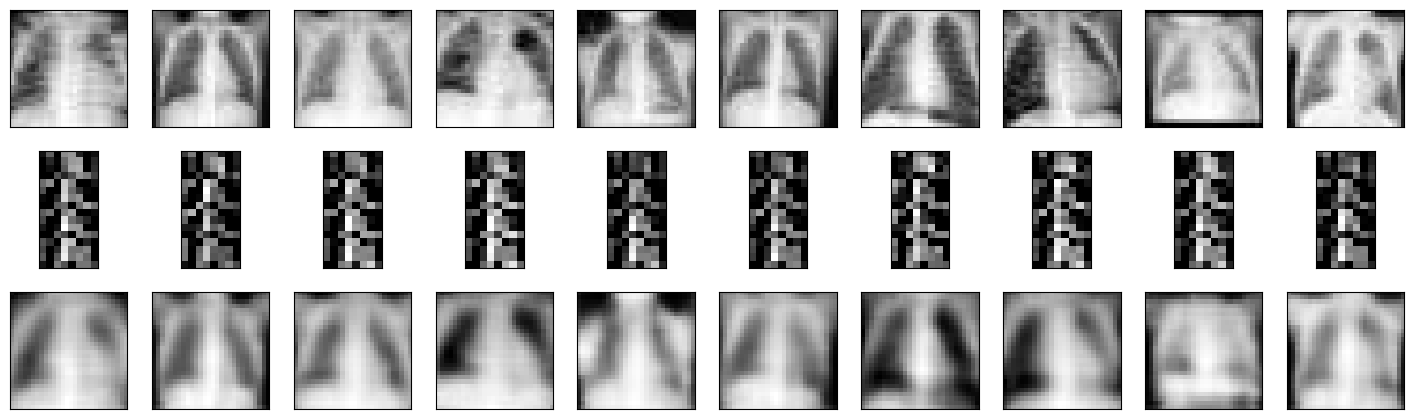

In [29]:
n_images = 10
test_images = np.random.randint(0, x_test.shape[0], size = n_images)
plt.figure(figsize=(18,18))
for i, image_index in enumerate(test_images):
  # Original images
  ax = plt.subplot(10,10, i + 1)
  plt.imshow(x_test[image_index].reshape(28,28), cmap='gray')
  plt.xticks(())
  plt.yticks(())

  # Coded images
  ax = plt.subplot(10,10, i + 1 + n_images)
  plt.imshow(coded_test_images[image_index].reshape(16,8), cmap='gray')
  plt.xticks(())
  plt.yticks(())

  # Decoded images
  ax = plt.subplot(10,10, i + 1 + n_images * 2)
  plt.imshow(decoded_test_images[image_index].reshape(28,28), cmap='gray')
  plt.xticks(())
  plt.yticks(())

In [30]:
X_train = encoder.predict(x_train)
X_test = encoder.predict(x_test)

20/20 [==============================] - 0s 2ms/step


In [31]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4708, 128)
(624, 128)
(4708, 1)
(624, 1)


In [45]:
from sklearn.feature_selection import SelectKBest, f_classif

num_features = 32
selector = SelectKBest(f_classif, k=num_features)
X_train_new = selector.fit_transform(X_train, y_train.ravel())

# Transform both training and test data
X_train_new = selector.transform(X_train)
X_test_new = selector.transform(X_test)

print("New shape of training data: ", X_train_new.shape)
print("New shape of test data: ", X_test_new.shape)

New shape of training data:  (4708, 32)
New shape of test data:  (624, 32)


/home/caesar/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 24  25 101 111] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/caesar/.local/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [46]:
X_train = X_train_new
X_test = X_test_new

In [47]:
# data scaling
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

In [48]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [49]:
# Run a binary SVC classifier
# Create and fit the model

# Define the parameter ranges
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': ['scale', 'auto',100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']} 

grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=3)

grid.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.924 total time=   0.1s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.941 total time=   0.1s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.936 total time=   0.1s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.929 total time=   0.1s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.928 total time=   0.1s
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.914 total time=   0.1s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.936 total time=   0.1s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.929 total time=   0.1s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.922 total time=   0.1s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.923 total time=   0.1s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.928 total time=   0.1s
[CV 2/5] END ...C=0.1, gamma=scale, kernel=pol

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': ['scale', 'auto', 100, 10, 1, 0.1, 0.01,
                                   0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']},
             verbose=3)

In [50]:
# Print the best parameters
print(grid.best_params_)

# Predict the test set results
grid_predictions = grid.predict(X_test)

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [51]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, grid_predictions)

print(f"Accuracy: {accuracy * 100}%")


Accuracy: 85.25641025641025%


              precision    recall  f1-score   support

           0       0.94      0.65      0.77       234
           1       0.82      0.97      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.81      0.83       624
weighted avg       0.87      0.85      0.85       624



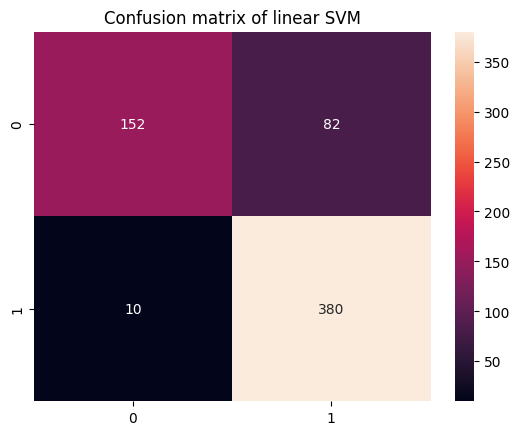

In [52]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test,grid_predictions)
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion matrix of linear SVM') # fmt='d' formats the numbers as digits, which means integers

print(classification_report(y_test,grid_predictions))

In [54]:
clf = grid.best_estimator_
clf.get_params()
print(clf.n_support_)

[303 310]


In [55]:
# get the actual output of SVM
decision_function = clf.decision_function(X_test)
print(decision_function)

[ 3.52336828  3.81653114  0.9323562  -2.3266021   3.365716    2.9794388
  2.83310044  3.51423857  3.85080035  0.58737561  4.74635893  1.61696243
  2.04817192  4.98213569  2.2665708   2.46912331  3.70932822 -0.80582186
  1.7242837  -1.79565488 -1.41560604  3.52558697  1.03275562  0.66672707
  1.91646907 -3.36779588  2.009633   -1.6817718   1.21741457  4.62776833
  1.9089531   1.47105254  3.27346572  3.23725343  3.2038274   3.67432074
 -3.69745539  3.33696444  0.11176327  1.93677315  4.10592479 -1.80870517
 -1.57542632 -1.33049565  2.67755811  4.03819177 -2.15167107  3.59795011
  1.60407888  3.10049694 -1.28761047  1.97073572 -1.12498141  2.80129289
 -1.75678413 -1.97282793  3.47928961 -2.21691501 -1.60666264  2.9233453
 -1.79261631  0.90708524 -1.44544675  2.2300246   3.00177278  3.23496044
 -0.95273471  3.05921519  0.69705376 -1.82099376  3.20617128  3.52780549
 -0.82117606  3.32373318  2.37407218  3.27374949  1.74228777 -0.11277113
  1.04010945  3.30369445  3.79008581  2.51589022  2.7

In [59]:
import numpy as np
print("svc.gamma: ", clf._gamma)
print("svc.degree: ", clf.degree)

sv=open("../data-kernel-model-rbf/support_vectors_rbf.txt","w")
dual_coeff=open("../data-kernel-model-rbf/dual_coeff_rbf.txt","w")
intercept=open("../data-kernel-model-rbf/intercept_rbf.txt","w")
xtestSample="../data-kernel-model-rbf/xtest_rbf.txt"
ytestSample="../data-kernel-model-rbf/ytest_rbf.txt"
ytestClassificationScore="../data-kernel-model-rbf/yclassificationscore.txt"
gammaValue="../data-kernel-model-rbf/gamma.txt"

np.savetxt(sv,clf.support_vectors_)
    
np.savetxt(dual_coeff,clf.dual_coef_,delimiter=' ')
np.savetxt(intercept,clf.intercept_,delimiter=' ')

with open(xtestSample, "w") as f1:
    for item in X_test[0]:  # Access the first row directly
        f1.write(str(item) + " ")
        
with open(ytestClassificationScore, "w") as f2:
    f2.write(str(decision_function[0]))
    
with open(ytestSample, "w") as f3:
    f3.write(str(y_test[0]))
    
with open(gammaValue, "w") as f4:
    f4.write(str(clf._gamma))
    
sv.close()
dual_coeff.close()
intercept.close()
f1.close()
f2.close()
f3.close()
f4.close()

svc.gamma:  1
svc.degree:  3


In [57]:
print(str(clf._gamma))
print(str(clf.intercept_))

1
[1.66107983]


In [58]:
print(clf.support_vectors_[0].shape)

(32,)
